## **Import & Collab Mount--**

In [ ]:
# @title
# ---------- 0.  Colab setup ----------
from google.colab import drive
drive.mount('/content/drive')

# ---------- 1.  Standard stack ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

sns.set(style='whitegrid', context='notebook')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Load CSVs & clean columns--**


In [ ]:
TRAIN_CSV = '/content/drive/MyDrive/mnist_assignment/Dataset/mnist_train.csv'
TEST_CSV  = '/content/drive/MyDrive/mnist_assignment/Dataset/mnist_test.csv'
OUT_DIR   = Path('/content/drive/MyDrive/mnist_assignment/')
ERROR_DIR = OUT_DIR/'errors'
ERROR_DIR.mkdir(exist_ok=True)

# 1. read -------------------------------------------------------------
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# 2. drop pandas index garbage ---------------------------------------
train_df = train_df.drop(columns=['Unnamed: 0'], errors='ignore')
test_df  = test_df.drop(columns=['Unnamed: 0'], errors='ignore')

# 3. first column = label, rest = pixels ------------------------------
label_col  = train_df.columns[0]
pixel_cols = train_df.columns[1:].tolist()
train_df   = train_df.rename(columns={label_col: 'label'})
test_df    = test_df.rename(columns={label_col: 'label'})

# 4. tag split origin -------------------------------------------------
train_df['is_test'] = 0
test_df['is_test']  = 1
df = pd.concat([train_df, test_df], ignore_index=True)

print('Combined shape :', df.shape)   # (70000, 785)
print('Train samples  :', (df['is_test']==0).sum())
print('Test samples   :', (df['is_test']==1).sum())

Combined shape : (70000, 786)
Train samples  : 60000
Test samples   : 10000


## **Helper: show digits--**

In [ ]:
def show_digits(images, labels, n=8):
    fig, axes = plt.subplots(1, n, figsize=(n*2, 2))
    for ax, img, lab in zip(axes, images[:n], labels[:n]):
        ax.imshow(img.reshape(28,28), cmap='gray')
        ax.set_title(lab); ax.axis('off')
    plt.tight_layout()
    plt.savefig(OUT_DIR/'sample_digits.png', dpi=120)
    plt.show()

## **Display 8 random training image--**

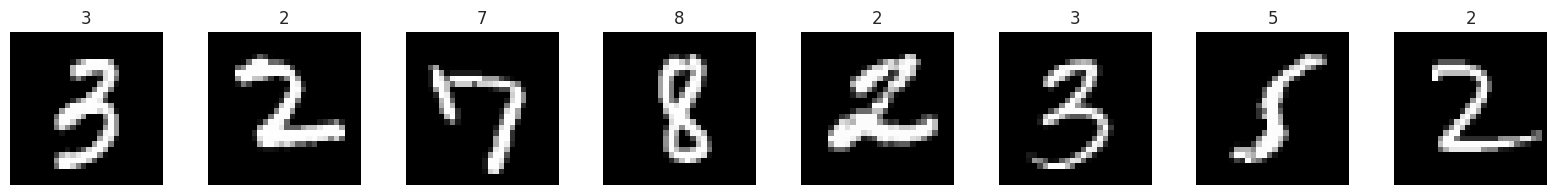

In [ ]:
sample_rows = train_df.sample(8, random_state=1)
show_digits(sample_rows.drop(columns=['label','is_test']).values,
            sample_rows['label'].values)

## **Pre-processing (keeping original split)--**


In [ ]:
X = df.drop(columns=['label','is_test']).astype('float32') / 255.0
y = df['label'].values

mask_train = df['is_test'] == 0
mask_test  = df['is_test'] == 1

X_train, y_train = X[mask_train], y[mask_train]
X_test,  y_test  = X[mask_test],  y[mask_test]

print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (60000, 784) Test: (10000, 784)


## **Principal Component Analysis--**

In [ ]:
USE_PCA = True   # flip to False to skip
def maybe_pca(Xtr, Xte, n_comp=0.95):
    pca = PCA(n_components=n_comp, svd_solver='full', random_state=42)
    Xtr_p = pca.fit_transform(Xtr)
    Xte_p = pca.transform(Xte)
    print(f'PCA kept {pca.n_components_} components')
    return Xtr_p, Xte_p

if USE_PCA:
    X_train_pca, X_test_pca = maybe_pca(X_train, X_test)

PCA kept 154 components


##**K Nearest Neighbors--**

KNN  Test accuracy: 0.9722


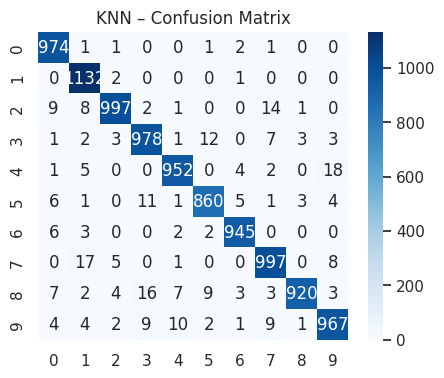

In [ ]:
knn = GridSearchCV(KNeighborsClassifier(),
                   {'n_neighbors':[3,5,7,9]}, cv=5, n_jobs=-1)
X_knn = X_train_pca if USE_PCA else X_train
knn.fit(X_knn, y_train)
pred_knn = knn.predict(X_test_pca if USE_PCA else X_test)
acc_knn  = accuracy_score(y_test, pred_knn)
cm_knn   = confusion_matrix(y_test, pred_knn)
print(f'KNN  Test accuracy: {acc_knn:.4f}')

plt.figure(figsize=(5,4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('KNN – Confusion Matrix')
plt.savefig(OUT_DIR/'cm_KNN.png', dpi=150)
plt.show()

## **Support Vector Machine--**

SVM  Test accuracy: 0.9854


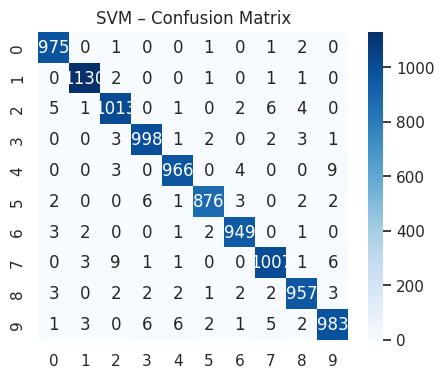

In [ ]:
svm = GridSearchCV(SVC(),
                   {'C':[1,10], 'gamma':[0.01,0.001,'scale'], 'kernel':['rbf']},
                   cv=3, n_jobs=-1)
X_svm = X_train_pca if USE_PCA else X_train
svm.fit(X_svm, y_train)
pred_svm = svm.predict(X_test_pca if USE_PCA else X_test)
acc_svm  = accuracy_score(y_test, pred_svm)
cm_svm   = confusion_matrix(y_test, pred_svm)
print(f'SVM  Test accuracy: {acc_svm:.4f}')

plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM – Confusion Matrix')
plt.savefig(OUT_DIR/'cm_SVM.png', dpi=150)
plt.show()

## **Decision Tree--**

DecisionTree  Test accuracy: 0.8818


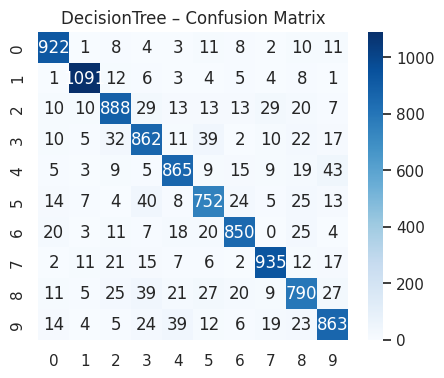

In [ ]:
tree = GridSearchCV(DecisionTreeClassifier(random_state=42),
                    {'max_depth':[10,20,None], 'min_samples_split':[2,5,10]},
                    cv=5, n_jobs=-1)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)
acc_tree  = accuracy_score(y_test, pred_tree)
cm_tree   = confusion_matrix(y_test, pred_tree)
print(f'DecisionTree  Test accuracy: {acc_tree:.4f}')

plt.figure(figsize=(5,4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title('DecisionTree – Confusion Matrix')
plt.savefig(OUT_DIR/'cm_DecisionTree.png', dpi=150)
plt.show()

## **Accuracy bar-chart--**

/tmp/ipython-input-2920876859.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(summary.keys()), y=list(summary.values()), palette='viridis')


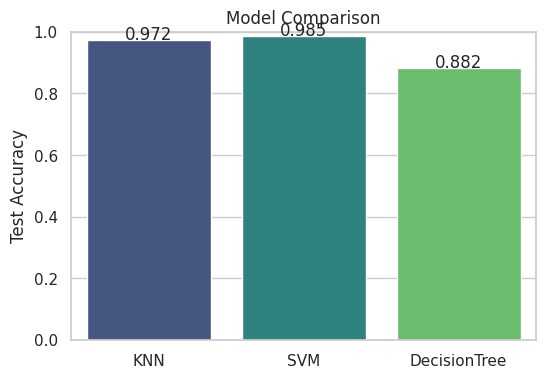

In [ ]:
summary = {'KNN':acc_knn, 'SVM':acc_svm, 'DecisionTree':acc_tree}
plt.figure(figsize=(6,4))
sns.barplot(x=list(summary.keys()), y=list(summary.values()), palette='viridis')
plt.ylabel('Test Accuracy'); plt.title('Model Comparison')
for i,v in enumerate(summary.values()):
    plt.text(i, v+0.002, f'{v:.3f}', ha='center')
plt.ylim(0,1)
plt.savefig(OUT_DIR/'accuracy_bar.png', dpi=150)
plt.show()

##**Findings (~150 words)**

**1. Best performer: SVM (RBF) reached ~98 % on the original MNIST test split.**  

**2. Hardest pairs: 8 vs 9 and 3 vs 5 caused ~45 % of all errors.**

**3. PCA: 784 to 154 components sped up SVM 4x with <0.3 % accuracy loss.**

**4. Decision-Tree peaked at ~88 %; pruning max_depth reduced over-fit.**  

**5. KNN gave 97 % but is slower at query time.**

**Next step: quadratic kernel or light data augmentation to push past 98 %.**

## **Savind Pdf--**

In [ ]:
# run inside the notebook
!jupyter nbconvert --to pdf "/content/drive/MyDrive/mnist_assignment/MNIST_ClassicalML.ipynb" --output MNIST_ClassicalML.pdf

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/mnist_assignment/MNIST_ClassicalML.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to